# Community Detection Algorithms

We apply three distinct algorithms to detect community structures within the network. These methods rely on different mathematical definitions of what constitutes a "community".

### Louvain Algorithm: 
The Louvain method is a heuristic algorithm based on Modularity Optimization. It is a greedy, iterative method that works in two phases:
1. Local Moving: Nodes are moved to neighbor communities if the move increases the graph's modularity ($Q$)
2. Aggregation: The graph is rebuilt where communities become single "super-nodes," and edge weights are summed. This process repeats until modularity no longer increases.

<cite>
Blondel, V. D., Guillaume, J. L., Lambiotte, R., & Lefebvre, E. (2008). Fast unfolding of communities in large networks. Journal of statistical mechanics: theory and experiment, 2008(10), P10008.
</cite>

Documentation for the implementations used in this notebook: [NetworkX Louvain](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html)

### Leiden Algorithm
The Leiden algorithm is an improvement upon Louvain. It addresses the issue of disconnected communities and generally yields partitions with higher quality. It introduces a refinement phase between the moving and aggregation steps:
1. Local Moving: Similar to Louvain (fast modularity optimization).
2. Refinement: Communities are locally split to ensure they are well-connected.
3. Aggregation: The network is aggregated based on the refined partition.

<cite>
Traag, V. A., Waltman, L., & Van Eck, N. J. (2019). From Louvain to Leiden: guaranteeing well-connected communities. Scientific reports, 9(1), 1-12.
</cite>

Documentation for the implementations used in this notebook: [leidenalg](https://leidenalg.readthedocs.io/en/stable/reference.html)

### Spectral Clustering
Spectral Clustering uses the eigenvalues (spectrum) of the graph's Laplacian matrix to perform dimensionality reduction before clustering.
1. Construct the Laplacian matrix from the graph's adjacency matrix.
2. Compute the first $k$ eigenvectors to embed the nodes into a lower-dimensional space.
3. Apply a standard clustering algorithm (like K-Means) on these vectors to separate the nodes. Unlike Louvain/Leiden which optimize density, Spectral Clustering approximates the Min-Cut problem (minimizing the number of edges cut to separate the graph).

Documentation for the implementations used in this notebook: [sklearn SpectralClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html)

<cite>
Ng, A., Jordan, M., & Weiss, Y. (2001). On spectral clustering: Analysis and an algorithm. Advances in neural information processing systems, 14.
</cite>

In [40]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import SpectralClustering
from collections import defaultdict
import time
import warnings
warnings.filterwarnings('ignore')

from utils import (
    load_email, run_leiden,
    metric_avg_conductance, metric_internal_density, metric_coverage, metric_ari,
    visualize_static_entire_graph, visualize_communities
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
G = load_email(directed=False)
gt = nx.get_node_attributes(G, 'ground_truth')

print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")
print(f"Is Directed: {G.is_directed()}")

Nodes: 986
Edges: 16064
Is Directed: False


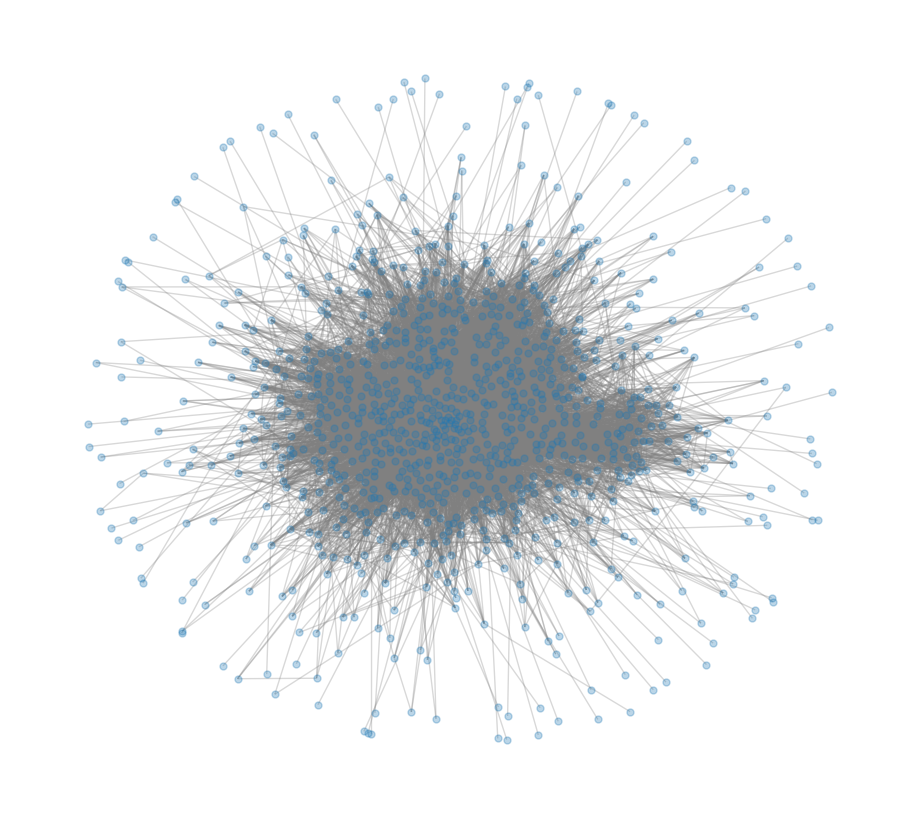

In [42]:
visualize_static_entire_graph(G, node_size= 25)

## Experimental Setup

To objectively compare community detection algorithms, we implemented a parameter grid search that optimizes for structural integrity rather than the algorithm's own objective function (e.g., Modularity). This prevents circular reasoning where an algorithm is "best" simply because it maximizes the metric it was designed to optimize.

### Composite Structural Score

We define a custom Composite Score to rank partitions. This score balances separation (how isolated communities are) with cohesion (how connected members are).

$\text{Composite Score} = 0.4 \times (1 - \text{Conductance}) + 0.3 \times \text{Density} + 0.3 \times \text{Coverage}$

The metrics are as follows
1. Avg Conductance (Lower is better): Measures the "leakiness" of communities (fraction of edges leaving the set). We invert this ($1 - C$) so that higher values contribute positively.
2. Avg Internal Density (Higher is better): Measures how tightly connected the nodes are within a community.
3. Coverage (Higher is better): The fraction of total graph edges that exist within the detected communities.

### Grid Search

We iterate through a range of hyperparameters for each algorithm:
- Louvain & Leiden: Resolution Parameter ($0.2$ to $5.0$).
- Spectral Clustering: Number of Clusters $k$ ($5$ to $65$).

Selection vs. Validation:
- Selection: The "Best" model is selected purely based on the unsupervised Composite Score.
- Validation: We calculate the Adjusted Rand Index (ARI) against the Ground Truth (Departments) for the selected model.

In [43]:
def optimize_community_detection(G, algorithm_name, param_range, ground_truth=None):
    results = []
    print(f"--- Optimizing {algorithm_name} ---")
    
    start_time = time.time()
    
    for param in param_range:
        try:
            # run algorithm
            if algorithm_name == "louvain":
                comms = nx.community.louvain_communities(G, resolution=param, seed=42)
            elif algorithm_name == "leiden":
                comms = run_leiden(G, resolution=param)
            elif algorithm_name == "spectral":
                # spectral uses k (int)
                k = int(param)
                adj = nx.to_scipy_sparse_array(G, format='csr')
                adj.indices = adj.indices.astype(np.int32)
                adj.indptr = adj.indptr.astype(np.int32)
                sc = SpectralClustering(n_clusters=k, affinity='precomputed', 
                                      assign_labels='discretize', random_state=42, n_init=10)
                labels = sc.fit_predict(adj)
                
                d = defaultdict(set)
                for node, label in zip(G.nodes(), labels): d[label].add(node)
                comms = list(d.values())
        except Exception as e:
            continue

        # metrics
        cond = metric_avg_conductance(G, comms)
        dens = metric_internal_density(G, comms)
        cov = metric_coverage(G, comms)
        
        # composite Score: 40% (1-Conductance) + 30% Density + 30% Coverage
        composite_score = (0.4 * (1 - cond)) + (0.3 * dens) + (0.3 * cov)
        
        # Check ARI (Reference only)
        ari = metric_ari(G, comms, ground_truth) if ground_truth else None
        
        results.append({
            "Algorithm": algorithm_name.capitalize(),
            "Param": param,
            "Communities": len(comms),
            "Composite_Score": composite_score,
            "Conductance": cond, # Lower is better
            "Density": dens,     # Higher is better
            "Coverage": cov,     # Higher is better
            "ARI": ari           # Higher is better
        })

    end_time = time.time()
    duration = end_time - start_time
    print(f"{algorithm_name} finished in {duration:.2f} seconds.")

    return pd.DataFrame(results)

In [44]:
# A. Resolution-based Algorithms (Louvain / Leiden)
resolutions = np.linspace(0.2, 5.0, 20)
df_leiden = optimize_community_detection(G, "leiden", resolutions, gt)
df_louvain = optimize_community_detection(G, "louvain", resolutions, gt)

# B. Count-based Algorithms (Spectral)
k_values = range(5, 65, 5) 
df_spectral = optimize_community_detection(G, "spectral", k_values, gt)

--- Optimizing leiden ---
leiden finished in 1.89 seconds.
--- Optimizing louvain ---
louvain finished in 5.36 seconds.
--- Optimizing spectral ---
spectral finished in 2.88 seconds.


### Hyperparameter Ranges

- Left Panel (Resolution Optimization):
    - Compares Leiden (Green) and Louvain (Blue) across resolution parameters ranging from $0.2$ to $5.0$.
    - The peak of the curve represents the "structural sweet spot" where the community definitions are most mathematically robust.
    - A sharp drop-off typically indicates over-fragmentation (shattering communities) or under-segmentation (giant blobs).

- Right Panel (Cluster Count Optimization):
    - Evaluates Spectral Clustering by forcing the algorithm to find $k$ partitions ($5$ to $65$).
    - The Red Dotted Line at $k=42$ represents the Ground Truth (the actual number of departments).
    - Interpretation: Ideally, the peak of the composite score (Purple square) should align with the red line. **This shows a conflict between the graph's topology (math) and its labels (reality).**

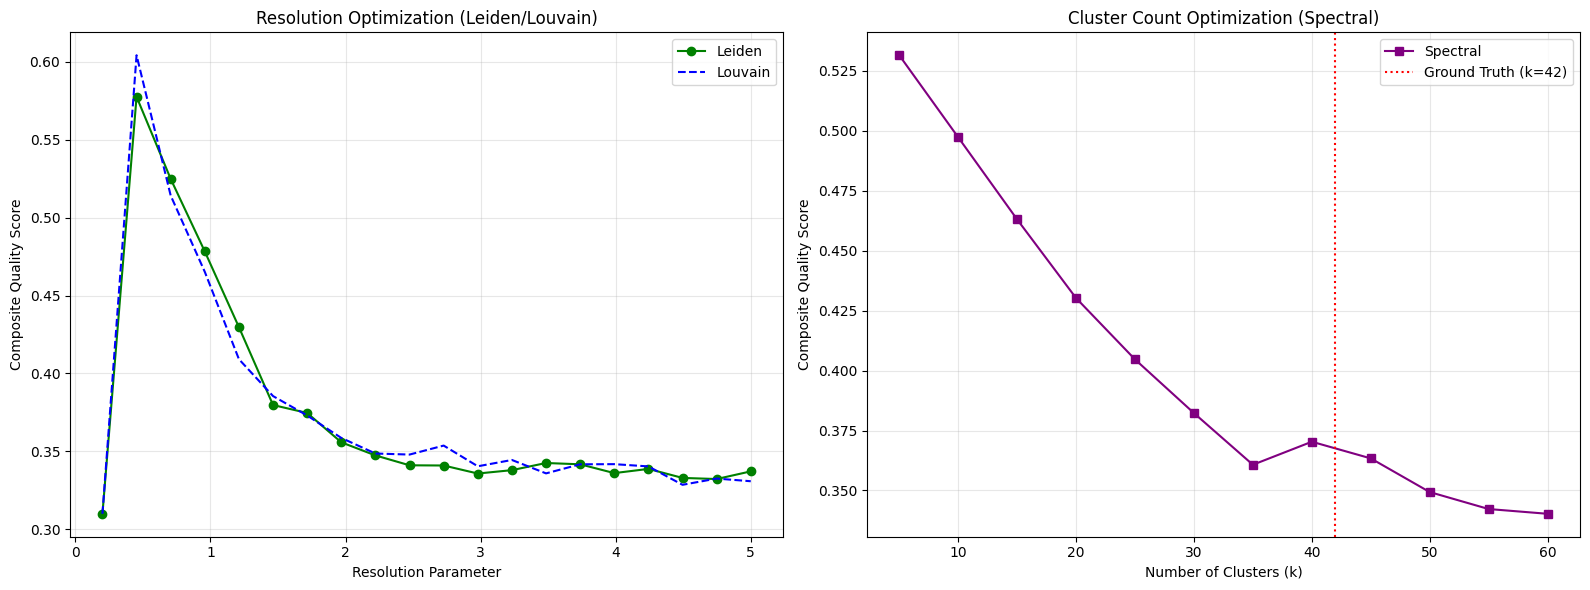

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Resolution Optimization
ax1.plot(df_leiden['Param'], df_leiden['Composite_Score'], label='Leiden', color='green', marker='o')
ax1.plot(df_louvain['Param'], df_louvain['Composite_Score'], label='Louvain', color='blue', linestyle='--')
ax1.set_title("Resolution Optimization (Leiden/Louvain)")
ax1.set_xlabel("Resolution Parameter")
ax1.set_ylabel("Composite Quality Score")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: K Optimization
ax2.plot(df_spectral['Param'], df_spectral['Composite_Score'], label='Spectral', color='purple', marker='s')
ax2.axvline(x=42, color='red', linestyle=':', label='Ground Truth (k=42)')
ax2.set_title("Cluster Count Optimization (Spectral)")
ax2.set_xlabel("Number of Clusters (k)")
ax2.set_ylabel("Composite Quality Score")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Min 5 Communities

To avoid trivial partitions (e.g., 2 giant communities), we filter out results with fewer than 5 detected communities when selecting the best model.

Mathematically, the algorithms maximize structural quality (Composite Score $\approx 0.53$) by partitioning the graph into 6 large communities. While these partitions are structurally robust (low Conductance), the low ARI ($\approx 0.20$) indicates they represent larger organizational divisions rather than specific departments.

In [46]:
def get_best_granular_model(df, min_communities=5):
    """Selects the best score provided the partition isn't trivial (too few groups)"""
    # reasonable number of communities (avoiding the '2 blobs' result)
    granular_df = df[df['Communities'] >= min_communities].copy()
    if granular_df.empty: return df.loc[df['Composite_Score'].idxmax()] # Fallback
    return granular_df.loc[granular_df['Composite_Score'].idxmax()]

# select best GRANULAR models
best_leiden = get_best_granular_model(df_leiden)
best_louvain = get_best_granular_model(df_louvain)
best_spectral = get_best_granular_model(df_spectral)

# combine
summary_df = pd.DataFrame([best_leiden, best_louvain, best_spectral])
summary_df.set_index("Algorithm", inplace=True)

display_cols = ["Param", "Communities", "Composite_Score", "ARI", "Conductance", "Density", "Coverage"]
final_view = summary_df[display_cols]

styled_table = final_view.style.background_gradient(
    cmap='Greens', subset=["Composite_Score", "ARI", "Density", "Coverage"]
).background_gradient(
    cmap='Greens_r', subset=["Conductance"] # Low is good
).format("{:.4f}")

print("\nBest Granular Configurations (min 5 communities)")
display(styled_table)


Best Granular Configurations (min 5 communities)


,Param,Communities,Composite_Score,ARI,Conductance,Density,Coverage
Algorithm,,,,,,,
Leiden,0.7053,6.0000,0.5249,0.2068,0.3426,0.2057,0.6673
Louvain,0.7053,6.0000,0.5142,0.2004,0.3456,0.1738,0.6675
Spectral,5.0000,5.0000,0.5315,0.0990,0.3533,0.1394,0.7700


Detected 6 communities using Leiden with resolution 0.7053.

=== COMMUNITY STATISTICS (EMAIL) ===
community       | num_nodes      
---------------------------------
0               | 361            
1               | 243            
2               | 144            
3               | 113            
4               | 93             
5               | 32             


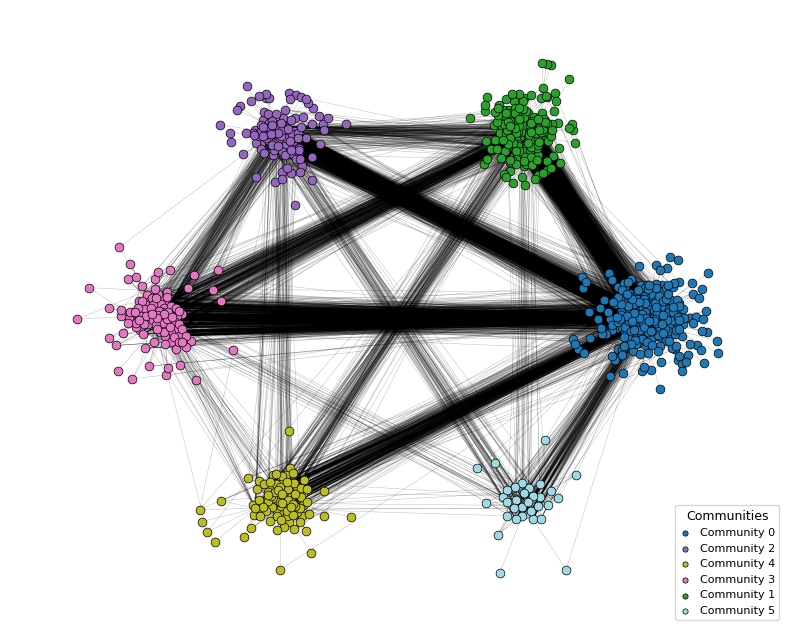

In [47]:
visualize_communities(G, method="leiden", resolution=0.7053, dataset_name="email")

Detected 17 communities using Louvain with resolution 0.7053.

=== COMMUNITY STATISTICS (EMAIL) ===
community       | num_nodes      
---------------------------------
0               | 117            
1               | 23             
2               | 95             
3               | 17             
4               | 8              
5               | 8              
6               | 76             
7               | 149            
8               | 31             
9               | 1              
10              | 291            
11              | 19             
12              | 116            
13              | 1              
14              | 2              
15              | 5              
16              | 27             


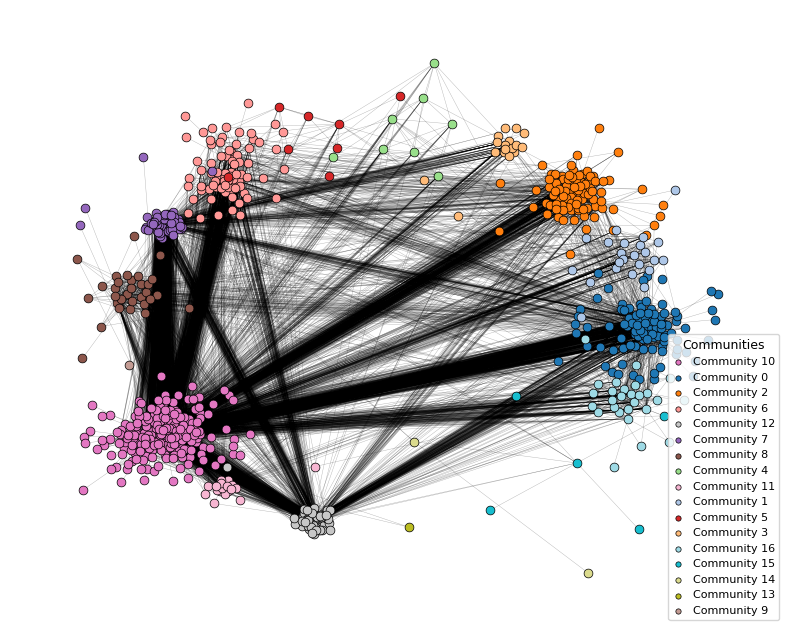

In [48]:
visualize_communities(G, method="louvain", resolution=0.7053, dataset_name="email")


=== COMMUNITY STATISTICS (EMAIL) ===
community       | num_nodes      
---------------------------------
0               | 66             
1               | 38             
2               | 25             
3               | 53             
4               | 804            


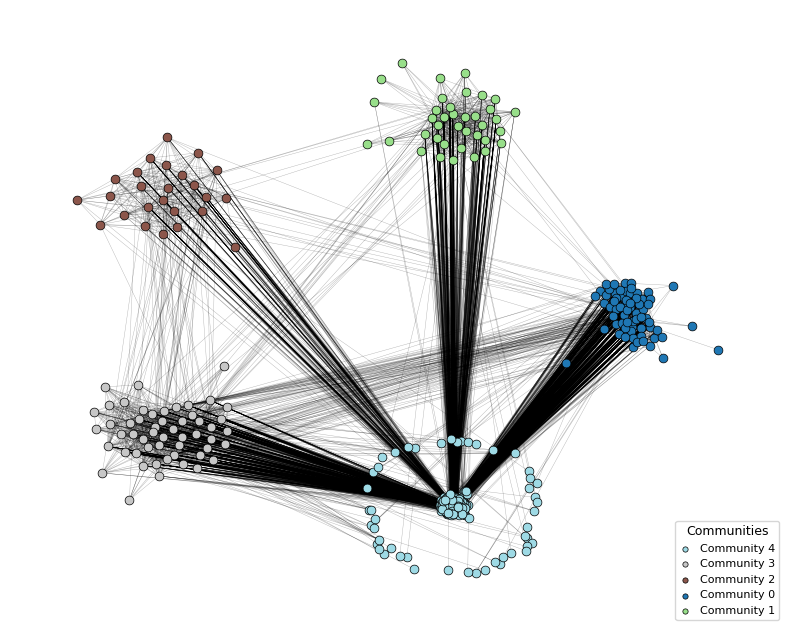

In [49]:
visualize_communities(G, method="spectral", k=5, dataset_name="email", n_neighbors=20)

### Min 40 Communities

By forcing a finer granularity, the Composite Score drops ($\approx 0.34$), meaning that the specific departments are more interconnected ("leakier") than the divisions. However, the ARI increases by a lot ($\approx 0.62$), confirming that the Ground Truth ($k=42$) exists at this lower scale of structural optimality.

In [50]:
def get_best_granular_model(df, min_communities=40):
    """Selects the best score provided the partition isn't trivial (too few groups)"""
    # reasonable number of communities (avoiding the '2 blobs' result)
    granular_df = df[df['Communities'] >= min_communities].copy()
    if granular_df.empty: return df.loc[df['Composite_Score'].idxmax()] # Fallback
    return granular_df.loc[granular_df['Composite_Score'].idxmax()]

# select best GRANULAR models
best_leiden = get_best_granular_model(df_leiden)
best_louvain = get_best_granular_model(df_louvain)
best_spectral = get_best_granular_model(df_spectral)

# combine
summary_df = pd.DataFrame([best_leiden, best_louvain, best_spectral])
summary_df.set_index("Algorithm", inplace=True)

display_cols = ["Param", "Communities", "Composite_Score", "ARI", "Conductance", "Density", "Coverage"]
final_view = summary_df[display_cols]

styled_table = final_view.style.background_gradient(
    cmap='Greens', subset=["Composite_Score", "ARI", "Density", "Coverage"]
).background_gradient(
    cmap='Greens_r', subset=["Conductance"] # Low is good
).format("{:.4f}")

print("\nBest Granular Configurations (min 40 communities)")
display(styled_table)


Best Granular Configurations (min 40 communities)


,Param,Communities,Composite_Score,ARI,Conductance,Density,Coverage
Algorithm,,,,,,,
Leiden,3.4842,51.0000,0.3425,0.6232,0.7928,0.4859,0.3795
Louvain,3.2316,45.0000,0.3445,0.6082,0.7844,0.4699,0.3909
Spectral,40.0000,40.0000,0.3703,0.4373,0.6900,0.4152,0.4059


### Algorithm Performance

- Leiden outperformed all models at the micro-scale (ARI $0.62$ vs Spectral $0.43$). This means that the departmental structure is defined by internal density (cliques of colleagues), which Leiden optimizes better, rather than by min-cuts, which Spectral attempts to find.
- Spectral Limitation: Even when forced to find $k=40$ clusters, Spectral Clustering achieved a significantly lower ARI. This suggests that the "cuts" required to isolate departments are not geometrically distinct in the eigenvector space, likely due to high edge overlap bewteen departments.